In [1]:
import os
import time
import itertools
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import category_encoders as ce

os.chdir('C:/Users/user/Desktop/Darui_R08621110')
os.getcwd()

'C:\\Users\\user\\Desktop\\Darui_R08621110'

### Preprocessing event data 

In [2]:
def array_f(array_repair):

    ## reorder cols
    cols = array_repair.columns.tolist() #store colnames
    cols = cols[3:4]+cols[1:3] #select id, tool_id(2), dft_mode(7)
    array_repair=array_repair[cols] #discard chip_id, rp_end_time

    ## dummy tool & dft (同一個 ID 中只要有用到就是1 沒有就是0)
    array_repair_dummy = pd.get_dummies(array_repair, columns = ['tool_id', 'dft_mode'])
    array_repair_dummy = array_repair_dummy.groupby(['id']).max().reset_index() #order by id
    
    return array_repair_dummy


def cell_test_f(cell_test):
    
    ## delete the tft_chip_id
    cols = cell_test.columns.tolist()
    cols = cols[-1:] + cols[1:3] 
    cell_test = cell_test[cols] # select id, test_user(1) and grade(7)

    ## dummy test_user & grade
    cell_test_dummy = pd.get_dummies(cell_test, columns = ['test_user', 'grade'])
    cell_test_dummy = cell_test_dummy.groupby(['id']).max().reset_index()
    
    return cell_test_dummy


def cell_repair_f(cell_repair):
    
    # delete the tft_chip_id and reorder
    cell_repair = cell_repair.iloc[:,2:] # discard tft_chip_id & product_code
    cols = cell_repair.columns.tolist()
    cols = cols[-1:] + cols[0:-2] # discard rework_time
    cell_repair = cell_repair[cols] # select id, eqp_id(2) and test_defect_code_desc(33)

    ## dummy eqp_id and test_defect_code_desc
    cell_repair_dummy = pd.get_dummies(cell_repair, columns = ['eqp_id', 'test_defect_code_desc'])
    cell_repair_dummy = cell_repair_dummy.groupby(['id']).max().reset_index()

    return cell_repair_dummy


def risk_db_f(risk_db):
    
    cols = risk_db.columns.tolist()
    cols = cols[-1:] + cols[-2:-1] + cols[0:2] # only reorder
    risk_db = risk_db[cols] # select id, lot_no, event_name(15) and process_stage(4)

    ## dummy stage_event
    risk_db['Stage_Event'] = risk_db['process_stage'].str.cat(risk_db[['event_name']], sep=' - ') # combine two variable
    risk_db = risk_db[['id', 'Stage_Event']] # only keep id and stage_event(16)
    risk_dummy = pd.get_dummies(risk_db, columns = ['Stage_Event'])
    risk_dummy = risk_dummy.groupby(['id']).max().reset_index()
    
    return risk_dummy


def module_f(Module):
    
    cols = Module.columns.tolist()
    cols = cols[2:5]+cols[1:2] # discard lot_no & cell_chip_id
    Module = Module[cols] # select shift_date, id, model_no(17) & GB

    ## dummy model_no
    Module_dummy = pd.get_dummies(Module, columns = ['model_no'])
    Module_dummy = Module_dummy.groupby(['id']).max().reset_index()

    ## reorder
    cols = Module_dummy.columns.tolist()
    cols = cols[3:] + cols[0:3]
    Module_dummy = Module_dummy[cols]
   
    return Module_dummy


def DataSet_Sorted(array_repair, cell_test, cell_repair, risk_db, Module):
    
    #global DataSet
    pd.options.mode.chained_assignment = None
    
    cell_test_dummy = cell_test_f(cell_test)
    cell_repair_dummy = cell_repair_f(cell_repair)
    risk_dummy = risk_db_f(risk_db)
    array_repair_dummy = array_f(array_repair)
    Module_dummy = module_f(Module)
    runhist_array_dummy = runhist_array_f(runhist_array, id_mapping)

    #merge data
    CTC = cell_test_dummy.merge(cell_repair_dummy, how = 'outer', on = 'id')
    CTCR = CTC.merge(risk_dummy, how = 'outer',on = 'id')
    CTCRA = CTCR.merge(array_repair_dummy, how = 'inner',on = 'id')
    DataSet = CTCRA.merge(Module_dummy, how = 'inner', on = 'id').fillna(0)
    
    #drop not unique columns
    cols = DataSet.columns[DataSet.nunique() == 1]
    DataSet = DataSet.drop(cols, axis = 1)
    
    return DataSet

### Dividing train & test data (by date)

In [3]:
def Train_Test(DataSet, y_1 = 2021, m_1 = 1, d_1 = 31, y_2 = 2021, m_2 = 3, d_2 = 31):
    
    data = DataSet.copy()
    
    date = data['shift_date'].str.split("/",expand = True) # divide day, month and year
    date = date.astype(int)
    date.columns = ['month', 'day', 'year']
    DataSet_split = pd.concat([data,date], axis = 1) #combine with original dataframe
    DataSet_split = DataSet_split.drop('shift_date', axis = 1)  
    DataSet_split = DataSet_split.sort_values(by = ['year', 'month', 'day'])
    DataSet_split = DataSet_split.reset_index(drop = True)
    count_1 = DataSet_split[(DataSet_split.year==y_1)&(DataSet_split.month==m_1)&(DataSet_split.day<=d_1)].tail(1).index.item()
    count_2 = DataSet_split[(DataSet_split.year==y_2)&(DataSet_split.month==m_2)&(DataSet_split.day<=d_2)].tail(1).index.item()
    # search for counts of target date interval
    TrainingSet_0 = DataSet_split.iloc[:count_1+1, :-3]
    TestingSet_0 = DataSet_split.iloc[count_1+1:count_2+1, :-3]
    
    return TrainingSet_0, TestingSet_0, DataSet_split


def split_module(module, sep_date = '2021-05-01') :
    
        # define train & test by date in module data
    module_drop = module[['id', 'GB', 'shift_date']]
    module_dupli = module_drop.groupby(['id']).max().reset_index()
    date = module_dupli['shift_date'].str.split("-", expand = True)
    module_time = pd.concat([module_dupli, date], axis = 1)
    module_time = module_time.rename(columns = {0: 'year', 1: 'month', 2: 'day'})
    module_time = module_time.sort_values(by = ['year', 'month', 'day']).reset_index(drop = True)
    print('Dimension of unique id in module:', module_dupli.shape)
    
    # define the date
    divide = module_time[module_time['shift_date'] == sep_date].index.min()
    module_train  = module_time.loc[: divide-1].drop(columns = ['shift_date', 'year', 'month', 'day'])
    module_test = module_time.loc[divide:].drop(columns = ['shift_date', 'year', 'month', 'day']).reset_index(drop = True)
    print('Dimension of unique id in module_train:', module_train.shape,
         '\nDimension of unique id in module_test:', module_test.shape)
    
    return module_train, module_test

### Preprocessing runhist data

In [4]:
def runhist_array_m2to7(runhist_array, id_mapping, module, sep_date = '2021-05-01', no_dummy = False) :   

    # transform sheet_id to id
    new_array = runhist_array.merge(id_mapping, on = 'sheet_id', how = 'left')
    new_array = new_array.drop(columns = ['sheet_id', 'create_time', 'lot_no'])
    cols = new_array.columns.tolist()
    cols = cols[2:3] + cols[0:2]
    new_array = new_array[cols]
    
    # combine the carrier features 
    carrier_list = ['ADSPT'+ str(x) for x in list(range(100, 1000, 100))]
    new_array['eqp_split'] = [x.split('_')[0] for x in new_array['eqp_id_info']]

    label_eqp = []
    for i in range(len(new_array)) :
        if new_array['eqp_split'][i] in carrier_list :
            label_eqp.append(new_array['eqp_split'][i])
        else :
            label_eqp.append(new_array['eqp_id_info'][i])

    new_array['label_eqp'] = label_eqp
    array_nodummy = new_array.drop(columns = ['eqp_id_info', 'eqp_split'])

    # one-hot encoding
    if no_dummy == False :
        array_dummy = pd.get_dummies(array_nodummy, columns = ['label_eqp', 'op_id_info']) 
        #eqp_id_info(124), op_id_info(39)

    elif no_dummy =='eqp' :
        array_dummy = pd.get_dummies(array_nodummy, columns = ['op_id_info'])

    elif no_dummy == 'op' :
        array_dummy = pd.get_dummies(array_nodummy, columns = ['label_eqp'])
            
    array_done = array_dummy.groupby(['id']).max().reset_index()
    print('Dimension of unique id in runhist_array:', array_done.shape)
    
    # divide train/test & add GB
    module_train, module_test = split_module(module, sep_date)
    array_train = array_done.merge(module_train, on = 'id', how = 'inner')
    array_test = array_done.merge(module_test, on = 'id', how = 'inner').reset_index(drop = True)
    all_array = pd.concat([array_train, array_test]).reset_index(drop = True)
    print('Dimension of unique id in runhist_array_train:', array_train.shape,
         '\nDimension of unique id in runhist_array_test:', array_test.shape)

    return array_train, array_test, all_array


def runhist_array_m8to1(runhist_array, id_mapping, module, do_dummy = True) :
    
    # transform sheet-id to id
    new_array = runhist_array.merge(id_mapping, on = 'sheet_id', how = 'left') # all sheet_id in runhist_array are kept
    col = new_array.columns.tolist()
    col = col[5:6] + col[1:4] # discard lot_no
    new_array = new_array[col]
    
    # combine carrier features
    carrier_list = ['ADSPT'+ str(x) for x in list(range(100, 1000, 100))]
    new_array['eqp_split'] = [x.split('_')[0] for x in new_array['eqp_id_info']]

    label_eqp = []
    for i in range(len(new_array)) :
        if new_array['eqp_split'][i] in carrier_list :
            label_eqp.append(new_array['eqp_split'][i])
        else :
            label_eqp.append(new_array['eqp_id_info'][i])

    new_array['label_eqp'] = label_eqp
    array_nodummy = new_array.drop(columns = ['create_time', 'eqp_id_info', 'eqp_split'])

    # one-hot encoding
    if do_dummy :
        array_dummy = pd.get_dummies(array_nodummy, columns = ['label_eqp', 'op_id_info']) 
        #eqp_id_info(124), op_id_info(54)
        array_dummy = array_dummy.groupby(['id']).max().reset_index()
    
    # merge with module
    module_drop = module[['id', 'GB']]
    module_dupli = module_drop.groupby(['id']).max().reset_index()
    all_array = array_dummy.merge(module_dupli, on = 'id', how = 'inner')
    print('Dimension of unique id in runhist_array:', all_array.shape)

    return all_array


def runhist_array_old(runhist_array, id_mapping, combine = False):
    
    new_array = runhist_array.merge(id_mapping, on = 'sheet_id', how = 'left') # all sheet_id in runhist_array are kept
    col = new_array.columns.tolist()
    col = col[5:6] + col[1:4] # discard lot_no
    new_array = new_array[col]
    new_array['new_eqp'] = [x.split('_')[0] for x in new_array.eqp_id_info]
    new_array = new_array.drop(columns = ['create_time', 'eqp_id_info'])
    
    if combine == False:
        array_dummy = pd.get_dummies(new_array, columns = ['new_eqp', 'op_id_info']) 
        # eqp_id_info(348/57), op_id_info(54)
        array_dummy = array_dummy.groupby(['id']).max().reset_index()
    
    elif combine == True:
        new_array['op_eqp'] = new_array.op_id_info + '_' + new_array.new_eqp
        pair_array = new_array.drop(columns = ['op_id_info', 'new_eqp'])
        array_dummy = pd.get_dummies(pair_array, columns = ['op_eqp'])
        array_dummy = array_dummy.groupby(['id']).max().reset_index()
    
    return array_dummy 


def runhist_cell_old(runhist_cell, id_mapping) :
    
    new_cell = runhist_cell.merge(id_mapping.iloc[:,1:], on = 'sheet_id', how = 'left') # combine only id
    col = new_cell.columns.tolist()
    col = col[4:5] + col[1:3] # discard sheet_id, create_time
    new_cell = new_cell[col]

    cell_dummy = pd.get_dummies(new_cell, columns = ['eqp_id_info', 'op_id_info'])
    cell_dummy = cell_dummy.groupby(['id']).max().reset_index()
    
    return cell_dummy


def runhist_cell_m2to7(runhist_cell, id_mapping, module, sep_date = '2021-05-01', no_dummy = False) :
    
    # transform sheet_id to id
    id_array = runhist_cell_m2_m5.merge(id_mapping_m2_m5, on = 'sheet_id', how = 'inner')
    reduce_array = id_array.drop(columns = ['sheet_id', 'create_time', 'abbr_cat', 'lot_no'])
    new_array = reduce_array[['id', 'eqp_id_info', 'op_id_info']]

    # transform eqp features
    new_label = new_array['eqp_id_info'].copy()
    table = new_label.str.split('_', expand = True)
    for i in range(len(table)) :

        if table[2][i] in ['COOLING', 'HEATING', 'Cooling', 'Coater Unit', 'Pre Bake No'] :
            new_label[i] = table[0][i] + '_' + table[2][i]        

        elif all([table[2][i] == 'Oven', table[3][i] == 'L']) :
            new_label[i] = table[0][i] + '_Oven_L'

        elif table[3][i] == 'Unit' :
            new_label[i] = table[0][i][:8]

        elif table[3][i] == 'VA' :
            new_label[i] = table[0][i][:8] + table[3][i]

    new_array['label_eqp'] = new_label         
    array_nodummy = new_array.drop(columns = ['eqp_id_info', 'op_id_info'])

    # one-hot encoding
    if no_dummy == False :
        array_dummy = pd.get_dummies(array_nodummy, columns = ['label_eqp']) # 72
    else :
        array_dummy = array_nodummy

    array_done = array_dummy.groupby(['id']).max().reset_index()
    print('Dimension of unique id in runhist_array:', array_done.shape)

    # divide train/test & add GB
    module_train, module_test = split_module(module, sep_date)
    array_train = array_done.merge(module_train, on = 'id', how = 'inner')
    array_test = array_done.merge(module_test, on = 'id', how = 'inner').reset_index(drop = True)
    all_array = pd.concat([array_train, array_test]).reset_index(drop = True)
    print('Dimension of unique id in runhist_array_train:', array_train.shape,
         '\nDimension of unique id in runhist_array_test:', array_test.shape)

    return array_train, array_test, all_array


def array_cell(train_array, test_array, train_cell, test_cell, module, sep_date = '2021-05-01') :
    
    #merge array & cell
    array_GB = sum(train_array.GB) + sum(test_array.GB)
    cell_GB = sum(train_cell.GB) + sum(test_cell.GB)
    
    if array_GB >= cell_GB :
        join = 'left'
        train_cell = train_cell.drop(columns = ['GB'])
        test_cell = test_cell.drop(columns = ['GB'])
        
    else :
        join = 'right'
        train_array = train_array.drop(columns = ['GB'])
        test_array = test_array.drop(columns = ['GB'])
 
    test_runhist = test_array.merge(test_cell, on = 'id', how = join).fillna(0).reset_index(drop = True)
    train_runhist = train_array.merge(train_cell, on = 'id', how = join).fillna(0).reset_index(drop = True)
    
    # shift GB columns to be the last column
    cols = train_runhist.columns.to_list()
    GB_posi = np.where(train_runhist.columns == 'GB')[0][0]
    new_cols = cols[:GB_posi] + cols[(GB_posi + 1):] + cols[GB_posi:(GB_posi + 1)]
    
    train_runhist = train_runhist[new_cols]
    test_runhist = test_runhist[new_cols]
    
    return train_runhist, test_runhist

### Runhist data plot

In [5]:
def feature_distribution(runhist) :   
    
    # select index for label(array), op, label(cell)
    variable_no = [x for x in enumerate(all_runhist.columns)][1:]
    for i in range(len(variable_no)) :
        if variable_no[i][1][:2] == 'op' :
            index_op = i 
            break
    for i in range(len(variable_no)):
        if variable_no[index_op + i][1][:5] == 'label' :
            index_eqp = index_op + i
            break
    
    variables = runhist.iloc[:,1:].drop(columns = 'GB').apply(np.mean, axis = 0)
    eqp1 = variables[:index_op]
    op1 = variables[index_op:index_eqp]
    eqp2 = variables[index_eqp:]

    fig, axs = plt.subplots(2, 2, figsize = (12, 8), sharex = False)
    fig.suptitle('Features of Runhist Data')
    axs[0, 0].plot(list(range(len(eqp1))), eqp1, 'b.')
    #axs[0, 0].set_xlabel('Feature Index')
    axs[0, 0].set_ylabel('Probability')
    axs[0, 0].set_title('Distribution of label_eqp in array')
    axs[0, 1].plot(list(range(len(op1))), op1, 'r.')
    #axs[0, 1].set_xlabel('Feature Index')
    axs[0, 1].set_ylabel('Probability')
    axs[0, 1].set_title('Distribution of op_id_info in array')
    axs[1, 0].plot(list(range(len(eqp2))), eqp2, 'g.')
    axs[1, 0].set_xlabel('Feature Index')
    axs[1, 0].set_ylabel('Probability')
    axs[1, 0].set_title('Distribution of label_eqp in cell')
    axs[1, 1].plot(list(range(len(variables))), variables, 'y.')
    axs[1, 1].set_xlabel('Feature Index')
    axs[1, 1].set_ylabel('Probability')
    axs[1, 1].set_title('Distribution of All Features')
    
    
def distance_histogram(runhist) :    
    
    good = runhist[runhist.GB == 0].drop(columns = ['id', 'GB'])
    bad = runhist[runhist.GB == 1].drop(columns = ['id', 'GB'])
    good = np.array(good)
    bad = np.array(bad)

    pair_matrix = (bad[:, None, :] != good).sum(2)

    fig, axs = plt.subplots(ncols = 2, figsize = (12, 6))
    ax = sns.histplot(pair_matrix.flatten(), bins = 25, color = 'purple', ax = axs[0])
    ax.set(title = 'Distribution of Distance between Good & Bad Instances', xlabel = 'Hamming Distance')
    ax = sns.histplot(dis_matrix.flatten(), bins = 25, color = 'red', ax = axs[1])
    ax.set(title = 'Distribution of Distance between Bad Instances', xlabel = 'Hamming Distance')
    
    
def distance_heatmap(runhist, bad_in_month) :    
    
    good = runhist[runhist.GB == 0].drop(columns = ['id', 'GB'])
    bad = runhist[runhist.GB == 1].drop(columns = ['id', 'GB'])
    good = np.array(good)
    bad = np.array(bad)

    dis_matrix = (bad[:, None, :] != bad).sum(2)

    sns.set(rc = {'figure.figsize':(10,8)})
    sns.color_palette("vlag", as_cmap = True)
    ax = sns.heatmap(dis_matrix, cmap = 'vlag')
    cumsum = list(np.cumsum(bad_in_month))
    ax.hlines(cumsum, *ax.get_xlim(), color = 'black', linewidth = 0.6)
    ax.vlines(cumsum, *ax.get_xlim(), color = 'black', linewidth = 0.6)

### Viewing bad data
1. number of bad types, mean of each type, data counts in each type (in 'Bad_Types')
2. record all variable-combination of bad types (in 'Bad')
3. print out the id of all bad types in each month 

In [6]:
def Balance_Ratio(data, label = 'GB', n = 5):
    
    r = len(data[data[label] == 0]) / len(data[data[label] == 1])
    r = np.around(r, decimals = n)
    
    return r


def Bad_Type_def(DataSet_All, label = 'GB'):
    
    Data = DataSet_All.copy()
    Data['cb'] = Data[Data.columns[1:-1]].apply(lambda x:'_'.join(x.astype(str)), axis = 1) #join all the variable into a string
    Data[f'{label}_mean'] = Data.groupby('cb')[label].transform('mean') 
    #calculate mean of GB based on 'cb' variable each data possesses
    Data[f'{label}_count'] = Data.groupby('cb')[label].transform('count') # calculate data numbers share the same 'cb' variable
    Data['Bad_count'] = Data.groupby('cb')[label].transform('sum') # calculate #bad data (baesd on GB) 
    All_Bad = Data[Data[label] == 1]
    print('Number of Bad:', len(All_Bad))
    All_Bad = All_Bad.sort_values(['Bad_count', f'{label}_mean'], ascending = [False, False])
    Bad_Types = All_Bad.drop_duplicates(subset = 'cb')
    Bad_Types = Bad_Types[['cb', f'{label}_mean', 'Bad_count']].reset_index(drop = True) 
    # bad type number based on how many kinds of'cb' 
    print('Types of Bad:', len(Bad_Types), '\n')
    
    return Bad_Types


def TypeOfBad(df, Bad_Types, sorting = True, label = 'GB'):
    
    Set_Bad = df[df[label] == 1]
    Bad = []
    for j in range(len(Set_Bad)):
        Key = Set_Bad.iloc[:, 1:-1].apply(lambda x:'_'.join(x.astype(str)),axis = 1) # concatenate variables as a string
        index = Bad_Types[Bad_Types['cb'] == Key.values[j]].index.item()
        Bad.append(index)
        if sorting: 
            Bad.sort() # sorting = True

    print('Types of Bad :\n',Bad,'\n')
    
    return Bad

    
def Bad_Type_by_Time(DataSet_split, Bad_Types, label = 'GB'):
    
    data = DataSet_split
    
    TimeSeries = data.sort_values(['year', 'month', 'day']) ## BAD ID of each month
    for i in TimeSeries['month'].unique():

        print('Month',i,':\n')
        TS = TimeSeries[TimeSeries.month == i].iloc[:, :-3] #exclude day, month and year
        TypeOfBad(TS, Bad_Types, sorting = False, label = label) # view id of bad type in each month

## Data Processing
1. read 7 raw data
2. combine 7 dataframe 
3. split training & testing data by specific date  
4. view variables in runhist_array
5. identify bad data

In [18]:
##### event data######
module = pd.read_csv("event/Module_all.csv").iloc[:,1:]
risk_db = pd.read_csv("event/risk_db_all.csv").iloc[:,1:]
array_repair = pd.read_csv("event/array_repair_all.csv").iloc[:,1:]
cell_repair = pd.read_csv("event/cell_repair_all.csv").iloc[:,1:]
cell_test = pd.read_csv("event/cell_test_all.csv").iloc[:,1:]
DataSet = pd.read_csv("event/DataSet.csv").iloc[:,1:]
print('DataSet:', DataSet.shape)

module_m23 = pd.read_csv('event/data_m2m3/module.csv')
module_m45 = pd.read_csv('event/data_m4m5/module.csv')
module_m67 = pd.read_csv('event/data_m6m7/module.csv')
module_m2_m7 = pd.concat([module_m23, module_m45, module_m67])

##### runhist data #####
runhist_array_m1 = pd.read_csv('ARRAY_RunHist/runhist_array_m1.csv')
runhist_array_m2 = pd.read_csv('ARRAY_RunHist/runhist_array_m2m3.csv')
runhist_array_m8 = pd.read_csv('ARRAY_RunHist/runhist_array_m8m9m10m11.csv')
runhist_array_m12 = pd.read_csv('ARRAY_RunHist/runhist_array_m12.csv')
runhist_array_m23 = pd.read_csv('ARRAY_RunHist/data_runhist_array_m2m3/runhist_array.csv')
runhist_array_m45 = pd.read_csv('ARRAY_RunHist/data_runhist_array_m4m5/runhist_array.csv')
runhist_array_m67 = pd.read_csv('ARRAY_RunHist/data_runhist_array_m6m7/runhist_array.csv')
id_mapping_m23 = pd.read_csv('ARRAY_RunHist/data_runhist_array_m2m3/id_mapping.csv')
id_mapping_m45 = pd.read_csv('ARRAY_RunHist/data_runhist_array_m4m5/id_mapping.csv')
id_mapping_m67 = pd.read_csv('ARRAY_RunHist/data_runhist_array_m6m7/id_mapping.csv')
id_mapping_m1 = pd.read_csv('ARRAY_RunHist/id_mapping_m1.csv')
id_mapping_m2 = pd.read_csv('ARRAY_RunHist/id_mapping_m2m3.csv')
id_mapping_m8 = pd.read_csv('ARRAY_RunHist/id_mapping_m8m9m10m11.csv')
id_mapping_m12 = pd.read_csv('ARRAY_RunHist/id_mapping_m12.csv')
runhist_cell_m1 = pd.read_csv('ARRAY_RunHist/runhist_cell_m1.csv')
runhist_cell_m2 = pd.read_csv('ARRAY_RunHist/runhist_cell_m2m3.csv')
runhist_cell_m8 = pd.read_csv('ARRAY_RunHist/runhist_cell_m8m9m10m11.csv')
runhist_cell_m12 = pd.read_csv('ARRAY_RunHist/runhist_cell_m12.csv')
runhist_cell_m23 = pd.read_csv('ARRAY_RunHist/data_runhist_cell_m2m3/runhist_cell.csv')
runhist_cell_m45 = pd.read_csv('ARRAY_RunHist/data_runhist_cell_m4m5/runhist_cell_m4m5.csv')
runhist_cell_m67 = pd.read_csv('ARRAY_RunHist/data_runhist_cell_m6m7/runhist_cell.csv')

runhist_cell_boru = pd.read_csv('ARRAY_RunHist/binary_encoding_RunHistoryCell_label.csv').iloc[:, :76]
print('\nrunhist_cell_boru:', runhist_cell_boru.shape, '\n')

runhist_array_m8_m1 = pd.concat([runhist_array_m8, runhist_array_m12, runhist_array_m1])
runhist_array_m2_m7 = pd.concat([runhist_array_m23, runhist_array_m45, runhist_array_m67])
id_mapping_m8_m1 = pd.concat([id_mapping_m8, id_mapping_m12, id_mapping_m1])
id_mapping_m2_m7 = pd.concat([id_mapping_m23, id_mapping_m45, id_mapping_m67])
runhist_cell_m8_m1 = pd.concat([runhist_cell_m8, runhist_cell_m12, runhist_cell_m1])
runhist_cell_m2_m7 = pd.concat([runhist_cell_m23, runhist_cell_m45, runhist_cell_m67])

##### dimension of all the dataframes ######
print('Array_repair_m8_m3:', array_repair.shape,
      '\nCell_test_m8_m3:',cell_test.shape, 
      '\nCell_repair_m8_m3:', cell_repair.shape, 
      '\nRisk_db_m8_m3:', risk_db.shape, 
      '\nModule_m8_m3:', module.shape, 
      '\nModule_m2_m7:', module_m2_m7.shape, 
      '\nRunhist_array_m8_m1:', runhist_array_m8_m1.shape,
      '\nRunhist_array_m2_m7:', runhist_array_m2_m7.shape,
      '\nID_mapping_m8_m1:', id_mapping_m8_m1.shape, 
      '\nID_mapping_m2_m7:', id_mapping_m2_m7.shape, 
      '\nRunhist_cell_m8_m1:', runhist_cell_m8_m1.shape,
      '\nRunhist_cell_m2_m7:', runhist_cell_m2_m7.shape
)

DataSet: (136298, 84)

runhist_cell_boru: (133600, 76) 

Array_repair_m8_m3: (610816, 5) 
Cell_test_m8_m3: (388895, 4) 
Cell_repair_m8_m3: (10854, 6) 
Risk_db_m8_m3: (582277, 4) 
Module_m8_m3: (212958, 6) 
Module_m2_m7: (278282, 6) 
Runhist_array_m8_m1: (1767053, 4) 
Runhist_array_m2_m7: (3286465, 4) 
ID_mapping_m8_m1: (120289, 3) 
ID_mapping_m2_m7: (278282, 3) 
Runhist_cell_m8_m1: (1505312, 4) 
Runhist_cell_m2_m7: (2943513, 5)


### Event data

In [ ]:
##### merge 5 dataframes #####
DataSet = DataSet_Sorted(array_repair, cell_test, cell_repair, risk_db, Module, id_mapping, runhist_array)
print('Dimension of Merged Data:', DataSet.shape, '\nBR:', Balance_Ratio(DataSet))
DataSet_All = DataSet.copy()
DataSet_All = DataSet_All.drop('shift_date', axis = 1)

In [ ]:
##### output the event data #####
TrainingSet_0, TestingSet_0, DataSet_split = Train_Test(DataSet)
print('TrainingSet_0:', TrainingSet_0.shape, ', Balance Ratio:', Balance_Ratio(TrainingSet_0), \
      '\nTestingSet_0:', TestingSet_0.shape, ', Balance Ratio:', Balance_Ratio(TestingSet_0),'\n')

DataSet = pd.concat([TrainingSet_0, TestingSet_0])
DataSet.to_csv('DataSet.csv')
TrainingSet_0.to_csv('TrainingSet_0.csv')
TestingSet_0.to_csv('TestingSet_0.csv')

In [ ]:
##### output bad types #####
Bad_Types = Bad_Type_def(DataSet_All)
Bad_Types.to_csv('Bad_Types.csv')

Bad_Type_by_Time(DataSet_split, Bad_Types)
print('\nTrainingSet:')
train_bad = TypeOfBad(TrainingSet_0, Bad_Types, sorting = True)
print('\nTestingSet:')
test_bad = TypeOfBad(TestingSet_0, Bad_Types, sorting = True)

### Runhist data

#### process features

In [272]:
##### merge runhist array (m2-m7) #####
#array_old = runhist_array_m8to1(runhist_array_m8_m1, id_mapping_m8_m1, module, do_dummy = True)

runhist_array_m2_m5 = pd.concat([runhist_array_m23, runhist_array_m45])
id_mapping_m2_m5 = pd.concat([id_mapping_m23, id_mapping_m45])
module_m2_m5 = pd.concat([module_m23, module_m45])

train_array, test_array, all_array = runhist_array_m2to7(runhist_array_m2_m5, id_mapping_m2_m5, module_m2_m5, 
                                                         sep_date = '2021-05-01', no_dummy = False)

print('Balance Ratio of all runhist array:', Balance_Ratio(all_array))
train_array.to_csv('train_runhist.csv')
test_array.to_csv('test_runhist.csv')
all_array.to_csv('runhist.csv')

Dimension of unique id in runhist_array: (205790, 162)
Dimension of unique id in module: (210958, 3)
Dimension of unique id in module_train: (160125, 2) 
Dimension of unique id in module_test: (50833, 2)
Dimension of unique id in runhist_array_train: (157140, 163) 
Dimension of unique id in runhist_array_test: (48650, 163)
Balance Ratio of all runhist array: 1129.71429


In [275]:
##### merge runhist cell (m2-m7) #####
runhist_cell_m2_m5 = pd.concat([runhist_cell_m23, runhist_cell_m45])
id_mapping_m2_m5 = pd.concat([id_mapping_m23, id_mapping_m45])
module_m2_m5 = pd.concat([module_m23, module_m45])

train_cell, test_cell, all_cell = runhist_cell_m2to7(runhist_cell_m2_m5, id_mapping_m2_m5, module_m2_m5, 
                                                     sep_date = '2021-05-01', no_dummy = False)

print('Balance Ratio of all runhist cell:', Balance_Ratio(all_cell))
train_cell.to_csv('train_runhist.csv')
test_cell.to_csv('test_runhist.csv')
all_cell.to_csv('runhist.csv')

C:\Users\user\anaconda3\envs\aging\lib\site-packages\ipykernel_launcher.py:143: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Dimension of unique id in runhist_array: (205716, 73)
Dimension of unique id in module: (210958, 3)
Dimension of unique id in module_train: (160125, 2) 
Dimension of unique id in module_test: (50833, 2)
Dimension of unique id in runhist_array_train: (157091, 74) 
Dimension of unique id in runhist_array_test: (48625, 74)
Balance Ratio of all runhist cell: 1135.55249


In [276]:
##### merge runhist array & cell #####
train_runhist, test_runhist = array_cell(train_array, test_array, train_cell, test_cell, module, sep_date = '2021-05-01')
all_runhist = pd.concat([train_runhist, test_runhist])

print('Balance Ratio of all runhist data:', Balance_Ratio(all_runhist))
train_runhist.to_csv('train_runhist.csv')
test_runhist.to_csv('test_runhist.csv')
all_runhist.to_csv('runhist.csv')

Balance Ratio of all runhist data: 1129.71429


#### plot features

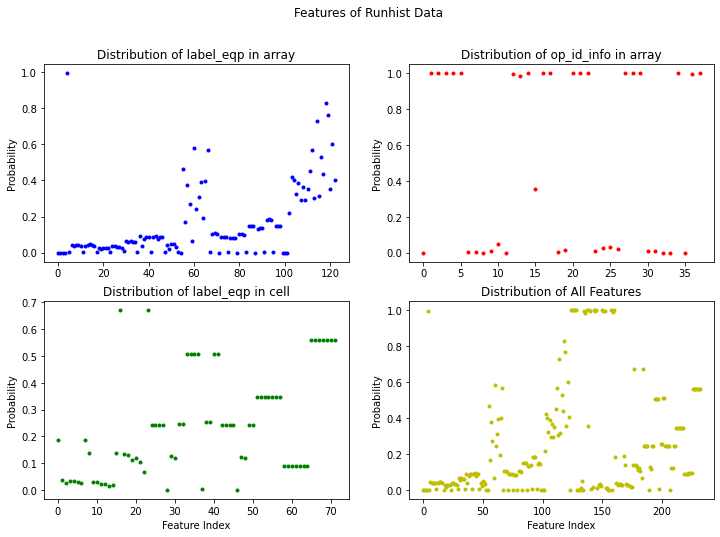

In [227]:
##### plot distribution of features #####
feature_distribution(all_runhist)

In [ ]:
##### for machine without chamber number (m8-m3) #####
no_number = ['ADRIE100', 'ADRIE200', 'ADRIE300', 'ADRIE400', 'ADRIE500', 'ADRIE600', 'ADRIE800', 'ADRIE900', 'ADRIEA00']
no_number2 = ['ADCVD100', 'ADCVD200', 'ADCVD300', 'ADCVD600', 'ADCVD700', 'ADCVD800', 'ADCVD900', 'ADCVDA00', 'ADCVDB00']
no_number.extend(no_number2)
col_target = ['label_eqp_' + x for x in no_number]

runhist_chamber = runhist[col_target]
bad_count = runhist_chamber.apply(lambda x : sum(x*runhist.GB), axis = 0)
chamber_mean = runhist_chamber.apply(np.sum, axis = 0)

fig, axs = plt.subplots(1, 2, figsize = (12, 4))
fig.suptitle('Machine without Chamber Number in Runhist_Array')
axs[0].plot(range(len(chamber_mean)), chamber_mean, 'b.', markersize = 15)
axs[0].set_xlabel('Variable Index')
axs[0].set_ylabel('Count')
axs[0].set_title('Counts in Each Machine')
axs[1].plot(range(len(bad_count)), bad_count, 'r.', markersize = 15)
axs[1].set_xlabel('Variable Index')
axs[1].set_ylabel('Count')
axs[1].set_title('Bad Counts in Each Machine')

#### plot distance

In [269]:
##### bad counts in module in each month #####
GB_inner_m8_m1 = module.merge(array_old['id'], on = 'id', how = 'inner')
date_m8_m1 = GB_inner_m8_m1.shift_date.str.split('/', expand = True).astype(int)
date_m8_m1.columns = ['month', 'day', 'year']

GB_inner_m2_m7 = module_m2_m7.merge(all_array['id'], on = 'id', how = 'inner')
date_m2_m7 = GB_inner_m2_m7.shift_date.str.split('-', expand = True).astype(int)
date_m2_m7.columns = ['year', 'month', 'day']

bad_counts = []
all_month = list(range(8, 13)) + list(range(1, 8))
for index, months in enumerate(all_month) :
    if index < 6 :
        month_index = np.logical_and(GB_inner_m8_m1.GB == 1, date_m8_m1.month == months)
        length = len(GB_inner_m8_m1[month_index])
    else :
        month_index = np.logical_and(GB_inner_m2_m7.GB == 1, date_m2_m7.month == months)
        length = len(GB_inner_m2_m7[month_index])
    
    bad_counts.append(length)
# all bad_counts = [8, 12, 13, 8, 17, 7, 31, 46, 54, 51, 7, 37]

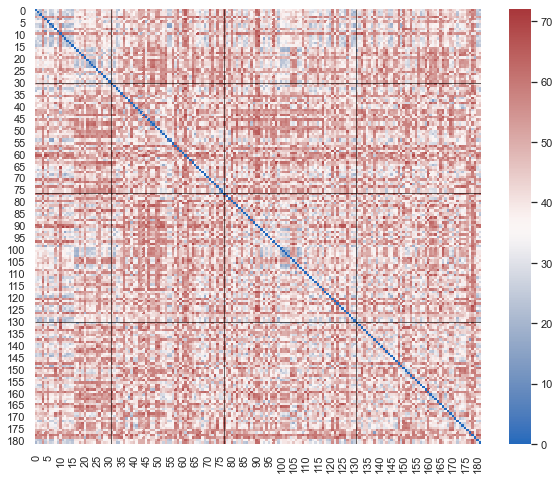

In [271]:
##### cauculate distance between bad instances #####
bad_counts = [8, 12, 13, 8, 17, 7, 31, 46, 54, 51, 7, 37]
distance_heatmap(all_runhist, bad_counts[6:10])

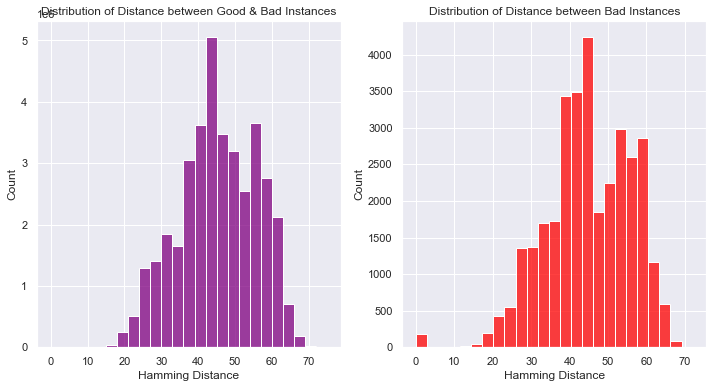

In [236]:
##### plot distance between instances #####
distance_histogram(all_runhist)

#### bad types

In [10]:
run_bad_types = Bad_Type_def(all_array)
#run_bad_types.to_csv('run_bad_types.csv')

Number of Bad: 182
Types of Bad: 182 

